FLUJO DE TRABAJO CUADRÍCULAS ESPECIES
===

Este es un ejemplo para usar las cuadrículas creadas en [workflow.ipynb](../../workflow.ipynb). 

Usaré Python para crear un mapa de calor para observar especies encontradas en Bandama.

Estas observaciones no tienen que ser únicamente de especies, pueden ser de otros tópicos.

In [1]:
# Importar librerías
import pandas as pd
import geopandas as gpd
import fiona
from shapely.geometry import Point
import os

C:\Users\jcge9\AppData\Local\Temp\ipykernel_19288\2990599079.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Usamos el paquete de fiona

Se usará el paquete de fiona para poder pasar los archivos SHP a KML

In [2]:
fiona.supported_drivers['KML'] = 'rw'

### Cargamos los datos en GeoDataFrames (geopandas)

1. Capa SHP del IDECanarias
2. Cuadrículas creadas 100 m x 100 m
3. Especies que he guardado en mi base de datos personal.

In [10]:
enp = gpd.read_file("../../data/enps_canarias/eennpp.shp")
bandama_grid = gpd.read_file("../../results/C-14.kml", driver = "kml")
especies_tsv = pd.read_csv("../data/coord_plantae.tsv", sep = "\t")

### Crear la capa de Bandama

In [11]:
bandama = enp[enp["nombre"] == "Bandama"]
bandama = bandama.to_crs(epsg=4326) 

### Procesados del archivo de Especies

Lo convertimos en GeoDataFrame

In [14]:
geometry = [
  Point(xy) for xy in zip(
    especies_tsv['longitude'], 
    especies_tsv['latitude']
    )
  ]
puntos_especie = gpd.GeoDataFrame(especies_tsv, geometry=geometry)
puntos_especie = puntos_especie.set_crs(epsg=4326, inplace=True)

### Intersa solo estudiar como ejemplo las especies nativas

In [15]:
gdf_especies = puntos_especie[puntos_especie["category"] == "Especie nativa"]
gdf_especies_nativa = gdf_especies[gdf_especies["category"] == "Especie nativa"]

Crear una nueva columna en el GeoDataFrame de las cuadrículas para numerar cada una de ellas.

In [17]:
bandama_grid["cuadricula"] = range(len(bandama_grid) )

### Combinar los GeoDataFrames

GeoDataFrame con la información combinada de las CUADRÍCULAS DE BANDAMA + PUNTOS DE LAS ESPECIES

In [18]:
#bandama_especies = 
bandama_species_cuadriculas = gpd.sjoin(bandama_grid, gdf_especies_nativa, how="left", predicate="contains").dropna(subset=['index_right'])

### Contar el número de especies por cuadrículas

De esta forma creamos una capa con las cuadrículas y el número de especies para ver la biodiversidad

In [19]:
ban_esp_cua_n = gpd.GeoDataFrame(
  (bandama_species_cuadriculas[["specie", "cuadricula", "geometry"]].
    groupby(["specie", "cuadricula", "geometry"]).
    size().
    reset_index(name="n")
  ), 
  geometry="geometry")

### Comprobar con un Plot

<Axes: >

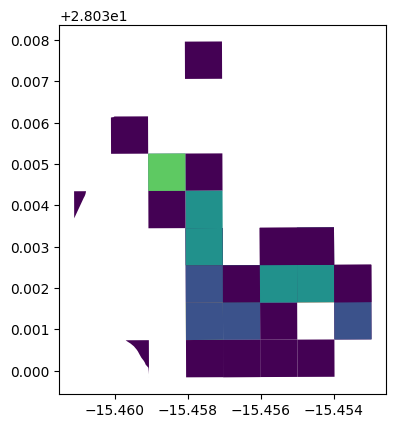

In [20]:
ban_esp_cua_n.plot(column="n")

## Descargamos los datos como un SHP 

In [21]:
ban_esp_cua_n.to_file("../data/bandama_especies.shp")